# Prithvi burn scars detection demo

Introducing Prithvi, an innovative temporal Vision Transformer jointly developed by the [collaborative efforts of IBM and NASA](https://www.earthdata.nasa.gov/news/impact-ibm-hls-foundation-model). This groundbreaking model was pretrained using continental US Harmonised Landsat Sentinel 2 (HLS) data. The focus of this demo is to highlight the model's refinement in detecting burn scars. Further details can be explored [here](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-burn-scar).

To facilitate burn scar detection, users are required to provide an HLS array that encompasses the following reflectance channels (ranging from 0 to 1): Blue, Green, Red, Narrow NIR, SWIR 1, and SWIR 2.

## Methodology

This demonstration employs a fine-tuned version of the Prithvi model to identify instances of burn scars in new data presented in a numpy array format. By way of illustration, we will employ this model to detect burn scars within the [`IFArafoCandelaria` fire](https://www.copernicus.eu/en/media/image-day-gallery/ifarafocandelaria-fire-still-burning-tenerife) in Tenerife.

The input data will be retrieved from the CMR-STAC API. The process involves searching for a specific subset by defining a region of interest and a designated time frame, all of which are tailored to suit our particular use case.

- **Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - [HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)**
    - _The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products._  
     - **Science Dataset (SDS) layers:** 
        - B12 (SWIR 2) 
        - B12 (SWIR 1) 
        - B8A (NIR Narrow)  
        - B04 (Red)   
        - B03 (Green) 
        - B02 (Blue) 


- **Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - [HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)**
    - _The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products._  
     - **Science Dataset (SDS) layers:**  
        - B07 (SWIR 2)  
        - B06 (SWIR 1)
        - B05 (NIR) 
        - B04 (Red) 
        - B03 (Green) 
        - B02 (Blue)  

## Setup

### Library import

In [1]:
import sys

# Include local library paths 
sys.path.append("../src/")

from map_interaction import LeafletMap  
from data_search import CMRSTACCatalog
from data_extraction import COGExtractor
from model_inference import ModelProcessor

/home/iker/mambaforge/envs/hls_data_project/lib/python3.11/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Data  acquisition
### Draw a rectangle on map to select and area

In [2]:
map = LeafletMap()
map

Draw a rectangle on map to select and area.


LeafletMap(center=[28.3904, -16.4409], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_tit…

In [16]:
map.geometry

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'style': {'stroke': True,
     'color': '#2BA4A0',
     'weight': 4,
     'opacity': 1,
     'fill': True,
     'fillColor': None,
     'fillOpacity': 0,
     'clickable': True}},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-16.693726, 28.195506],
      [-16.693726, 28.502488],
      [-16.311951, 28.502488],
      [-16.311951, 28.195506],
      [-16.693726, 28.195506]]]}}]}

### Search items on the CMR-STAC API

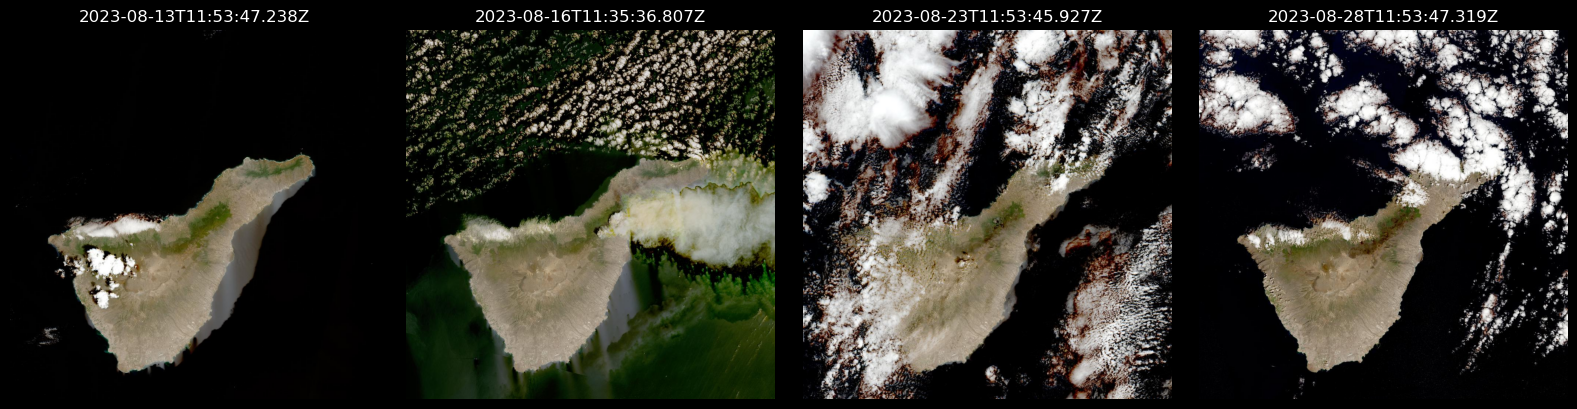

In [11]:
# Create and instance of a CMR STAC catalog
catalog = CMRSTACCatalog()

# Search for items of interest:
items = catalog.search(bbox=map.bbox, start_date='2023-08-13', end_date='2023-08-31')

# Display RGB images of all items in a single plot
catalog.display_rgb_images(items)

### Extracting HLS COGs from the Cloud

GDAL configurations set successfully.
Authentication to NASA Earthdata Login credentials set successfully.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/iker/mambaforge/envs/hls_data_project/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


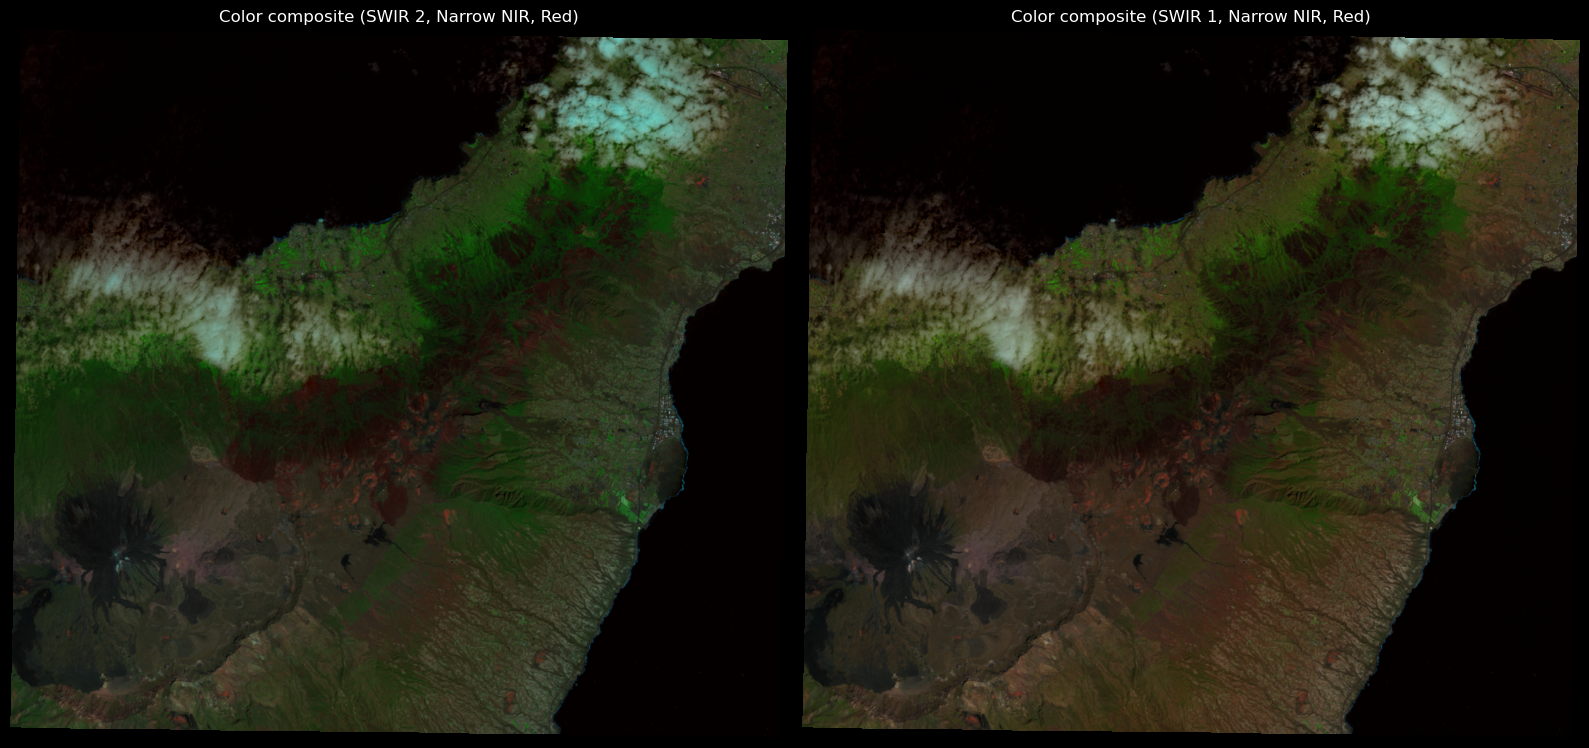

In [26]:
# Initialize COGExtractor
cog_extractor = COGExtractor(items[-1], map.polygon)  

# Get data
band_data = cog_extractor.get_data()

# Input array
input_array = cog_extractor.get_input_array(band_data)

# Display composites
cog_extractor.display_composites(band_data)

## Burn scards detection

/home/iker/mambaforge/envs/hls_data_project/lib/python3.11/site-packages/mmseg/models/decode_heads/decode_head.py:104: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'


load checkpoint from local path: ../Prithvi/checkpoints/burn_scars_Prithvi_100M.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


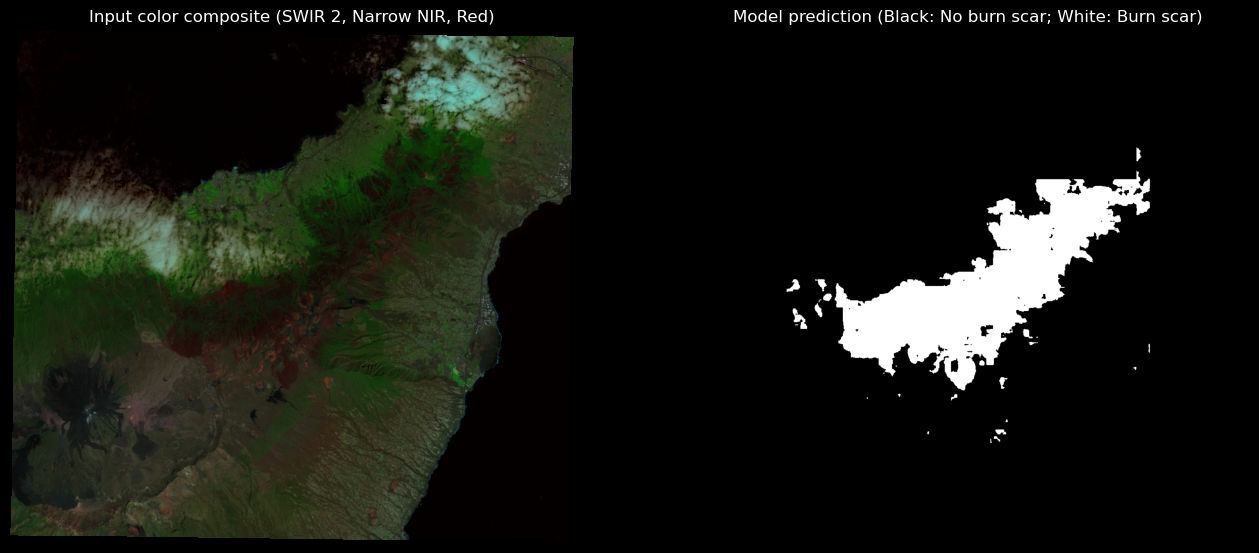

In [27]:
config_path = "../Prithvi/configs/burn_scars_Prithvi_100M_array.py"
ckpt = "../Prithvi/checkpoints/burn_scars_Prithvi_100M.pth"
bands = "[0,1,2,3,4,5]"

# Initialize ModelProcessor
model_processor = ModelProcessor(config_path, ckpt, bands)

# Get prediction
mask = model_processor.predict(input_array)

# Display input/output
model_processor.display_io(input_array)
